In [2]:
import cv2
import os, os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Conv2D, Dense, Input, Flatten, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, tanh
import matplotlib.pyplot as plt

In [3]:
# Define hyperparameters

optimizer = Adam(learning_rate=1e-4)
batch_size = 10
epochs = 1000
coef_reg = 0 # Coefficient for L2 regularizer of weights
coef_bias_reg = 0 # Coefficient for L2 regularizer of biases
act = 'relu' # Choice of activation functions (either relu or tanh)

In [4]:
def createDataset(img_folder, label_path,scale_percent=70):
# This function create dataset from a folder of images and a label file. 
# scale_percent is how much you want to scale the images down
# The outputs are a numpy array of images and a numpy array of locations of phones
    images = []
    labels = []
    f = open(label_path)
    lines = f.readlines()
    for line in lines:
        if(line.strip() != ""):
            img, x, y = line.split(" ")
            if(os.path.exists(os.path.join(img_folder,img))):
                img_ = cv2.imread(os.path.join(img_folder,img))
                width = int(img_.shape[1] * scale_percent / 100)
                height = int(img_.shape[0] * scale_percent / 100)
                dim = (width, height)
                images.append(cv2.resize(img_, dim, interpolation = cv2.INTER_AREA))
                labels.append([float(x),float(y)])
    return np.asarray(images).astype("float32"), np.asarray(labels).astype("float32") #tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

def getAccuracy(model, x, y):
# This function computes the accuracy of a model with respect to input x and the ground-truth label y
  y_pred = model.predict(x)
  diff = np.abs(y_pred - y)
  correct = 0
  for pair in diff:
    if(pair[0] <= 0.05 and pair[1] <= 0.05):
      correct += 1
  return correct / len(y)

In [5]:
x, y = createDataset("find_phone_data", "find_phone_data/labels.txt") # Build a training dataset
x = x/255  # Normalize the dataset
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, shuffle=True) # Split the dataset into training and validation

In [6]:
# Build a machine learning model for phone detection based on VGG-16

input = Input((x.shape[1], x.shape[2], x.shape[3]))
# 1st Conv Block

conv1 = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(input)
conv2 = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv1)
max1 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv2)
# 2nd Conv Block

conv3 = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max1)
conv4 = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv3)
max2 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv4)

# 3rd Conv block

conv5 = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max2)
conv6 = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv5)
conv7 = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv6)
max3 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv7)
# 4th Conv block

conv8 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max3)
conv9 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv8)
conv10 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv9)
max4 = MaxPool2D(pool_size =2, strides =2, padding ='same')(conv10)

# 5th Conv block

conv11 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(max4)
conv12 = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv11)
conv13 = Conv2D (filters =512, kernel_size =3, padding ='same', kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(conv12)
batch2 = BatchNormalization()(conv13)
if(act == 'relu'):
  act1 = relu(batch2)
elif(act == 'tanh'):
  act1 = tanh(batch2)
max5 = MaxPool2D(pool_size =2, strides =2, padding ='same')(act1)

# Fully connected layers

flat = Flatten()(max5)
dense1 = Dense(units = 4096, activation =act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(flat)
drop1 = Dropout(0.8)(dense1)
dense2 = Dense(units = 512, activation =act, kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(drop1)
output = Dense(units = 2, activation ='sigmoid', kernel_regularizer=L2(coef_reg), bias_regularizer=L2(coef_bias_reg))(dense2)

# Creating the model

model = Model (inputs=input, outputs =output)
model.compile(optimizer=optimizer, loss=tf.losses.MeanSquaredError(),metrics=['mae', 'mse'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 228, 343, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 228, 343, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 228, 343, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 114, 172, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 114, 172, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 114, 172, 128)     147584    
                                                             

2022-08-30 13:05:27.737809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 13:05:28.300438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6437 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1


In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001) # Reduce the learning rate when it is plateau
earlystop = EarlyStopping(monitor='val_loss', patience=20) # Early stop the training when there is no improvement
hist = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val), callbacks=[earlystop, reduce_lr])

Epoch 1/1000


2022-08-30 13:05:32.352175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-08-30 13:05:32.710047: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-30 13:05:33.282270: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 13:05:33.316305: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 13:05:33.487733: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

10/11 [==========================>...] - ETA: 0s - loss: 0.0578 - mae: 0.2075 - mse: 0.0578

2022-08-30 13:05:36.756088: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 13:05:36.779318: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


11/11 [==============================] - 9s 389ms/step - loss: 0.0573 - mae: 0.2065 - mse: 0.0573 - val_loss: 0.0517 - val_mae: 0.1975 - val_mse: 0.0517 - lr: 1.0000e-04
Epoch 2/1000
11/11 [==============================] - 3s 256ms/step - loss: 0.0559 - mae: 0.2057 - mse: 0.0559 - val_loss: 0.0518 - val_mae: 0.1976 - val_mse: 0.0518 - lr: 1.0000e-04
Epoch 3/1000
11/11 [==============================] - 3s 256ms/step - loss: 0.0553 - mae: 0.2060 - mse: 0.0553 - val_loss: 0.0519 - val_mae: 0.1975 - val_mse: 0.0519 - lr: 1.0000e-04
Epoch 4/1000
11/11 [==============================] - 3s 257ms/step - loss: 0.0506 - mae: 0.1968 - mse: 0.0506 - val_loss: 0.0502 - val_mae: 0.1943 - val_mse: 0.0502 - lr: 1.0000e-04
Epoch 5/1000
11/11 [==============================] - 3s 257ms/step - loss: 0.0399 - mae: 0.1561 - mse: 0.0399 - val_loss: 0.0504 - val_mae: 0.1944 - val_mse: 0.0504 - lr: 1.0000e-04
Epoch 6/1000
11/11 [==============================] - 3s 257ms/step - loss: 0.0265 - mae: 0.1276 -

Epoch 46/1000
11/11 [==============================] - 3s 268ms/step - loss: 0.0010 - mae: 0.0253 - mse: 0.0010 - val_loss: 0.0169 - val_mae: 0.1119 - val_mse: 0.0169 - lr: 1.0000e-04
Epoch 47/1000
11/11 [==============================] - 3s 267ms/step - loss: 0.0016 - mae: 0.0323 - mse: 0.0016 - val_loss: 0.0156 - val_mae: 0.1079 - val_mse: 0.0156 - lr: 1.0000e-04
Epoch 48/1000
11/11 [==============================] - 3s 269ms/step - loss: 0.0017 - mae: 0.0326 - mse: 0.0017 - val_loss: 0.0145 - val_mae: 0.1030 - val_mse: 0.0145 - lr: 1.0000e-04
Epoch 49/1000
11/11 [==============================] - 3s 265ms/step - loss: 0.0015 - mae: 0.0311 - mse: 0.0015 - val_loss: 0.0123 - val_mae: 0.0955 - val_mse: 0.0123 - lr: 1.0000e-04
Epoch 50/1000
11/11 [==============================] - 3s 266ms/step - loss: 0.0023 - mae: 0.0378 - mse: 0.0023 - val_loss: 0.0143 - val_mae: 0.1031 - val_mse: 0.0143 - lr: 1.0000e-04
Epoch 51/1000
11/11 [==============================] - 3s 267ms/step - loss: 0.0

In [15]:
model.save("phone_detection.h5")

In [1]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.title("Loss (MSE)")

NameError: name 'plt' is not defined

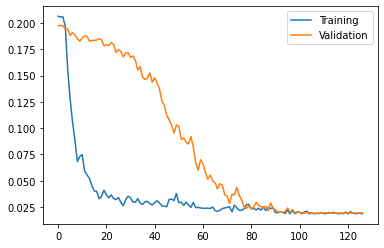

In [13]:
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.legend(["Training", "Validation"])
plt.title("MAE")

In [19]:
training_acc = getAccuracy(model, x_train, y_train)
val_acc = getAccuracy(model, x_val, y_val)
print(f"Training accuracy: {training_acc}\nVal accuracy: {val_acc}")

1/1 [==============================] - 0s 26ms/step
Training accuracy: 1.0
Val accuracy: 0.8461538461538461


In [56]:
def findPhone(img_path, model, scale_percent=70):
# This function is to locate a phone in the given image by a model
    img_ = cv2.imread(img_path)
    width = int(img_.shape[1] * scale_percent / 100)
    height = int(img_.shape[0] * scale_percent / 100)
    dim = (width, height)
    img_ = cv2.resize(img_, dim, interpolation = cv2.INTER_AREA)/255
    pred = model.predict(tf.expand_dims(img_, axis=0))
    return pred[0]

1/1 [==============================] - 0s 22ms/step


array([0.7612411, 0.4388348], dtype=float32)